# Bond Valuation Model

The following model calculates the basic bond statistics and runs a sensitivity analysis for a given US bond.

The risk of the corporate bond is taken into account not by calculating the expected cash flows given the default risk and payout ratio, as done in the previous version, but by discounting the cash flows by the discount rates according to the US yield curve in addition to the credit spread. 

The credit spread is calculated as follows:
$$
Credit\ spread\ (c) = (1 – Default\ Payout\ Ratio) • (Default\ Probability) 
$$

Which means that a cash flow at time $t$ is discounted by: 
$$
\left( 1+\frac{r+c}{n} \right)^{-n\ •\ t}
$$
where $n$ is the frequency of the coupon payments.

<br>

**N.B.** If you change the risk parameters (default payout ratio and default probability) the way the price of the bond reacts to changes in the maturity, number of coupons, etc. may change. These parameters are important. 


---

## Imports

Import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import requests
from scipy import interpolate


<br>

Import the spot rates.

In [2]:
base_site = 'https://www.federalreserve.gov/releases/H15/default.htm'     # Get the US YC data from the Fed's website
r  = requests.get(base_site)                                              # Use requests to obtain the data 
rates = pd.read_html(r.text)[0]                                           # Extract the data table
rates = rates.iloc[20:31, -1]                                             # Extract the relevant rates from the latest available date
rates = [float(i)/100 for i in rates]                                     # Generate a list with the decimal values of the curve
yc = pd.DataFrame( data = rates,                                          # Populate a DataFrame with the rates
                  index = [ 1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]) # Generate a numerical index
yc.columns = ['Rates']                                                    # Rename the Series
yc.index.names = ['T']                                                    # Rename the index
yc.T                                                                      # Print the transposed DataFrame


T,0.083333,0.250000,0.500000,1.000000,2.000000,3.000000,5.000000,7.000000,10.000000,20.000000,30.000000
Rates,0.0466,0.0484,0.0498,0.0499,0.0462,0.0435,0.0406,0.0398,0.0386,0.0405,0.0392


<br>

## Functions

In [3]:
def bootstrap(yc, T):                                                     # Create a function to bootstrap rates
    bootstrap = interpolate.interp1d(list(yc.index), 
                                     list(yc.Rates.values))    
    return bootstrap(T)
    
def bond_series(face, coupon, maturity, frequency, default_p, default_r):
    """
    A function to generate a list with a bond's cash flows.
    """
    periods = int(maturity*frequency)
    
    cf = []                                                               # Create an empty list that will house the CFs
    for c in range(periods-1):                                            # Loop through the payments; 'frequency' is the number of payments per year
        cf.append((face * (coupon / frequency)))                          # Structure the coupon payments                    
    cf.insert(periods, (face + face * (coupon / frequency)))              # Add last payment                            
    
    return cf

def bond_table(yc, face, coupon, maturity, frequency, default_p, default_r):    
    """
    A function to generate multiple Series that will then be evaluated by a separate function.
    The Series are outputted as a single DataFrame.
    """    
    periods = int(maturity*frequency)                                     # Generate a variable used for For Loop ranges - must be an integer
    c_spread = (1 - default_r)*default_p                                  # Calculate the credit spread
    
    T = [i/frequency for i in range(1, periods+1)]                        # List of maturities
    spot_rates = [float(bootstrap(yc, i)) for i in T]                     # List of spot rates
    adj_r = [i/frequency for i in spot_rates]                             # Spot rates adjusted for frequency
    CF = bond_series(face     = face,                                     # Cash flow series - can be modified to allow for real bond
                    coupon    = coupon, 
                    maturity  = maturity, 
                    frequency = frequency,
                    default_p = default_p,
                    default_r = default_r)
    
    dcf = []                                                              # Discounted cash flow series
    for i in range(periods):
        dcf.append(CF[i]/((1+(adj_r[i] + c_spread)/frequency)**(frequency*T[i])))
    
    w_dcf = []                                                            # Weighted DCF for duration
    for i in range(periods):
        w_dcf.append(dcf[i]*T[i])
    
    table = pd.DataFrame({'T'      : T,                                   # Repackage everything into a DataFrame
                          'Spot r' : spot_rates,
                          'Adj r'  : adj_r,
                          'E(CF)'  : CF,
                          'DCF'    : dcf,
                          'W DCF'  : w_dcf})
    return table

def calculate_stats(yc, face, coupon, maturity, frequency, default_p, default_r):
    """
    A function to calculate the statistics of a bond, using the previously calculated table.
    """
    periods = int(maturity*frequency)
    
    table = bond_table(yc        = yc,
                       face      = face, 
                       coupon    = coupon, 
                       maturity  = maturity, 
                       frequency = frequency,
                       default_p = default_p,
                       default_r = default_r)
    
    price = table.DCF.sum()                                               # Calculate bond present value (i.e., price)
    
    cf_list = list(table['E(CF)'])                                        # Extract the list of the cash flows of the bond
    cf_list.insert(0, -price)                                             # Insert a negative cash flow equal to the PV, at time = 0
    ytm = npf.irr(cf_list) * frequency                                    # Use NPF's IRR function to calculate the yield, and adjust for frequency
    
    mac_duration = table['W DCF'].sum() / price                           # Calculate MacCaulay Duration
    mod_duration = mac_duration / (1 + ytm/frequency)                     # Calculate Modified Duration
    
    c_dcf = []                                                            # Calculate convexity
    dcf = list(table.DCF)
    T = list(table.T)
    for i in range(periods):
        c_dcf.append(1/((1+ytm/frequency)**2)
                     *dcf[i]
                     *((i+1)**2+(i+1)))
    convexity = sum(c_dcf) / price / frequency**2
    
    
    bond_stats = pd.DataFrame({'PV'  : [price],
                               'YTM' : [ytm],
                           'Mac Dur' : [mac_duration],
                           'Mod Dur' : [mod_duration],
                           'Convex.' : [convexity]})
    
    return bond_stats

<br> 

## Example

In [4]:
face      = 100
coupon    = 4/100
maturity  = 5
frequency = 2
default_p = 1.2/100 # 1.2% is approximately equivalent to a Moody's Baa rating
default_r = 50/100  # Approximately the historically average payout ratio for corporates  

In [5]:
bond_table(yc, face, coupon, maturity, frequency, default_p, default_r)

,T,Spot r,Adj r,E(CF),DCF,W DCF
0,0.5,0.049800,0.024900,2.0,1.969570,0.984785
1,1.0,0.049900,0.024950,2.0,1.939508,1.939508
2,1.5,0.048050,0.024025,2.0,1.912563,2.868845
3,2.0,0.046200,0.023100,2.0,1.887714,3.775428
4,2.5,0.044850,0.022425,2.0,1.863739,4.659349
5,3.0,0.043500,0.021750,2.0,1.841296,5.523887
6,3.5,0.042775,0.021387,2.0,1.818371,6.364300
7,4.0,0.042050,0.021025,2.0,1.796375,7.185502
8,4.5,0.041325,0.020663,2.0,1.775281,7.988764
9,5.0,0.040600,0.020300,102.0,89.508171,447.540856


In [6]:
results = calculate_stats(yc, face, coupon, maturity, frequency, default_p, default_r)

pv        = float(results.PV)
ytm       = float(results.YTM)
mac_dur   = float(results['Mac Dur'])
mod_dur   = float(results['Mod Dur'])
convexity = float(results['Convex.'])

results

,PV,YTM,Mac Dur,Mod Dur,Convex.
0,106.312589,0.026439,4.598056,4.538065,23.928403


In [7]:
print(f'Credit Spread: {str(round(((1 - default_r)*default_p)*100, 2))} %')

Credit Spread: 0.6 %


<br>

## Charts & Sensitivity

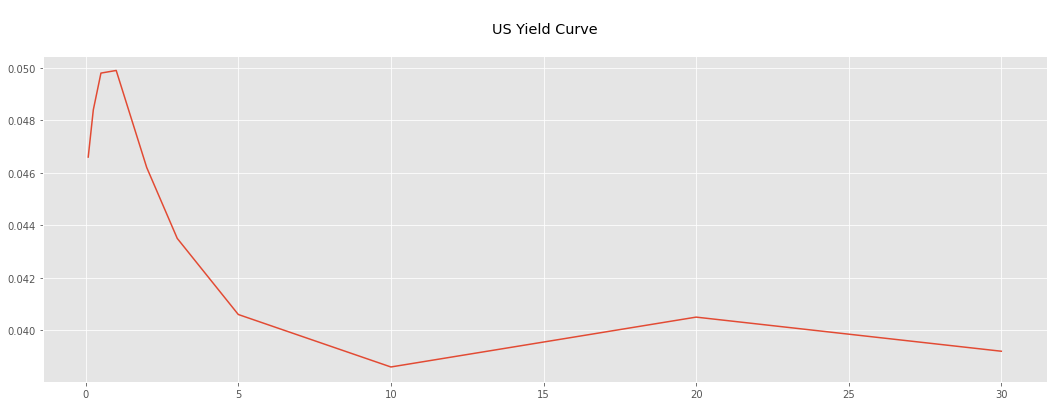

In [8]:
# Yield Curve
plt.figure(figsize = (18, 6)) 
plt.plot(yc)
plt.title('\nUS Yield Curve\n')
plt.show()

<br>

To illustrate the price sensitivity to interest rates, we run and plot three separate analyses:
1. Using the first approximation (Duration)
$$
\Delta P = -D*\Delta y 
$$
2. Using the second approximation (Convexity)
$$
\Delta P = -D*\Delta y + 0.5 * C * (\Delta y)^2
$$
3. Recalculating the price fully 

<br>

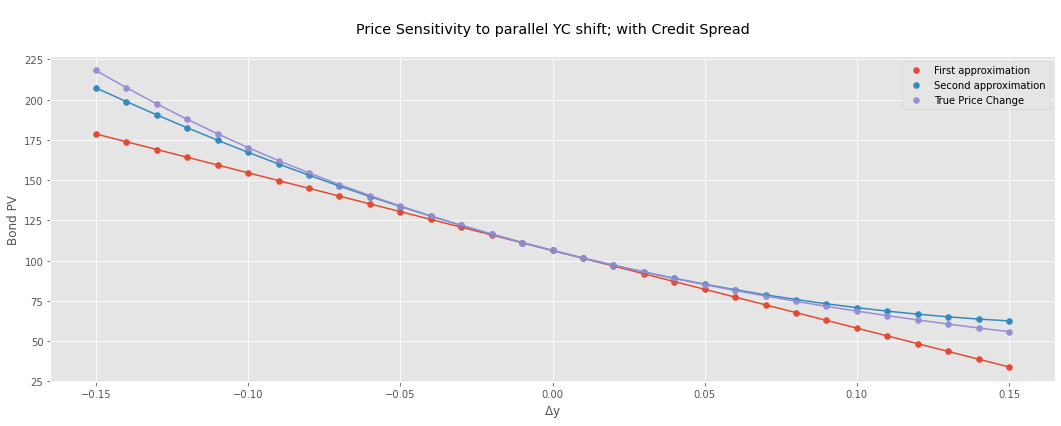

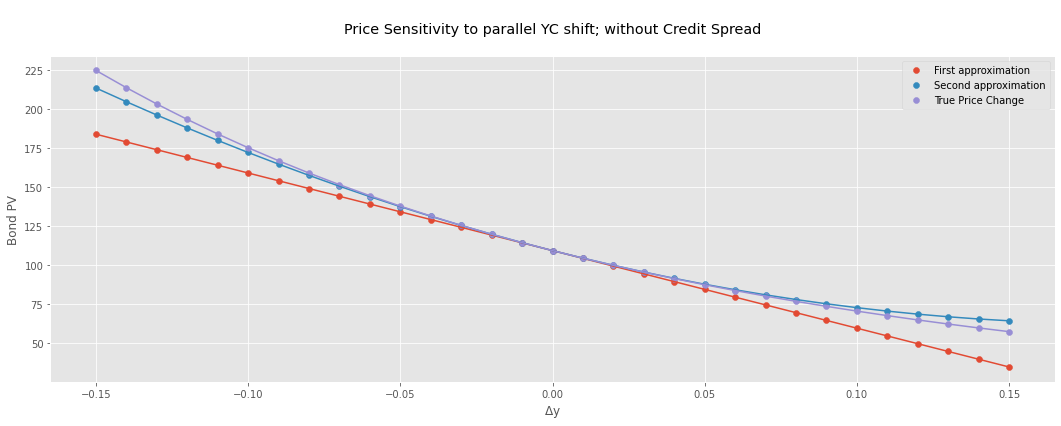

In [9]:
# Sensitivity to interest rate changes
rates_for_sensitivity = [i/100 for i in range(-15, 16)]
#rates_for_sensitivity.remove(0)

def first_approximation(delta_y):
    return pv*(1+(- mod_dur * delta_y))

def second_approximation(delta_y):
    return pv*(1+((- mod_dur * delta_y) + 0.5*convexity*delta_y**2))

def true_price_shift(delta_y, yc, face, coupon, maturity, frequency, default_p, default_r):
    yc_shifted = yc.copy()
    yc_shifted['Rates'] = [i+delta_y*frequency for i in yc['Rates']]
    stats = calculate_stats(yc_shifted, face, coupon, maturity, frequency, default_p, default_r)
    pv = float(stats.PV)
    return pv

fst_approx_pv = []
snd_approx_pv = []
tru_shift_pv  = []
for i in rates_for_sensitivity:
    fst_approx_pv.append(first_approximation(i))    
    snd_approx_pv.append(second_approximation(i))
    tru_shift_pv.append(true_price_shift(i, yc, face, coupon, maturity, frequency, default_p, default_r))    

plt.figure(figsize = (18, 6))     
plt.scatter(rates_for_sensitivity, fst_approx_pv)
plt.scatter(rates_for_sensitivity, snd_approx_pv)
plt.scatter(rates_for_sensitivity, tru_shift_pv)
plt.plot(rates_for_sensitivity, fst_approx_pv)
plt.plot(rates_for_sensitivity, snd_approx_pv)
plt.plot(rates_for_sensitivity, tru_shift_pv)
plt.title('\nPrice Sensitivity to parallel YC shift; with Credit Spread\n')
plt.xlabel('$\Delta$y')
plt.ylabel('Bond PV')
plt.legend(['First approximation', 'Second approximation', 'True Price Change'])
plt.show()

original_results = results.copy()
results = calculate_stats(yc, face, coupon, maturity, frequency, 0, default_r)
pv        = float(results.PV)
ytm       = float(results.YTM)
mac_dur   = float(results['Mac Dur'])
mod_dur   = float(results['Mod Dur'])
convexity = float(results['Convex.'])

fst_approx_pv = []
snd_approx_pv = []
tru_shift_pv  = []
for i in rates_for_sensitivity:
    fst_approx_pv.append(first_approximation(i))    
    snd_approx_pv.append(second_approximation(i))
    tru_shift_pv.append(true_price_shift(i, yc, face, coupon, maturity, frequency, 0, default_r))    

results = original_results.copy()
del original_results

print()

plt.figure(figsize = (18, 6))     
plt.scatter(rates_for_sensitivity, fst_approx_pv)
plt.scatter(rates_for_sensitivity, snd_approx_pv)
plt.scatter(rates_for_sensitivity, tru_shift_pv)
plt.plot(rates_for_sensitivity, fst_approx_pv)
plt.plot(rates_for_sensitivity, snd_approx_pv)
plt.plot(rates_for_sensitivity, tru_shift_pv)
plt.title('\nPrice Sensitivity to parallel YC shift; without Credit Spread\n')
plt.xlabel('$\Delta$y')
plt.ylabel('Bond PV')
plt.legend(['First approximation', 'Second approximation', 'True Price Change'])
plt.show()

In [10]:
# Show in numbers
yc_original = yc.copy()
pv_list = []

for delta_y in range(-15, 16):
    yc['Rates'] = [i+frequency*delta_y/100 for i in yc['Rates']]
    pv_list.append(round(float(calculate_stats(yc, face, coupon, maturity, frequency, default_p, default_r).PV), 2))
    yc = yc_original.copy()
del yc_original

price_approximations = {'$\Delta y$'    : [i/100 for i in range(-15, 16)],   
                        'First approx.' : fst_approx_pv,
                        'Second approx.': snd_approx_pv,
                        'True change'   : tru_shift_pv}

price_approximations = pd.DataFrame(price_approximations)

price_approximations

,$\Delta y$,First approx.,Second approx.,True change
0,-0.15,183.951917,213.592168,224.870028
1,-0.14,178.972032,204.791984,213.788692
2,-0.13,173.992147,196.255269,203.324648
3,-0.12,169.012262,187.982023,193.440230
4,-0.11,164.032377,179.972246,184.100260
5,-0.10,159.052492,172.225937,175.271873
6,-0.09,154.072607,164.743098,166.924347
7,-0.08,149.092722,157.523727,159.028960
8,-0.07,144.112838,150.567826,151.558846
9,-0.06,139.132953,143.875393,144.488869


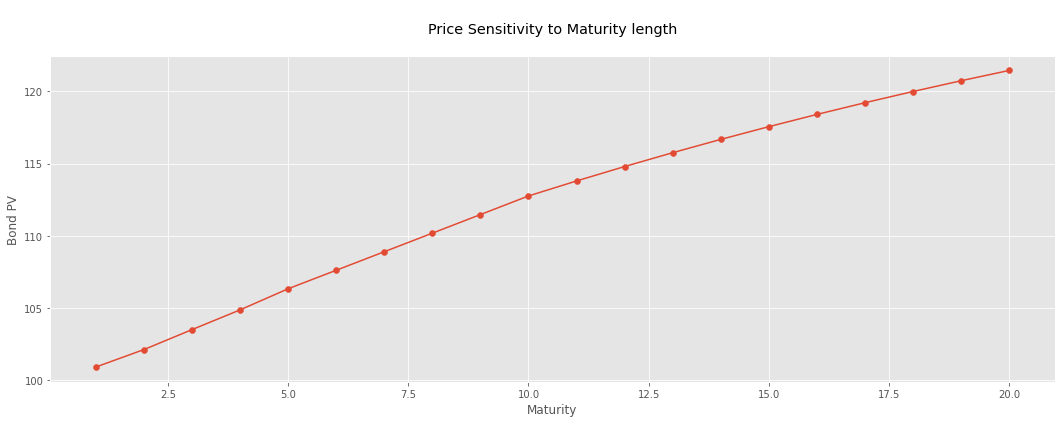

In [11]:
# Sensitivity to maturity
mats_for_sensitivity = [i for i in range(1, 21)]

pv_for_mat_sensitivity = []
for i in mats_for_sensitivity:
    pv_for_mat_sensitivity.append(float(calculate_stats(yc, face, coupon, i, frequency, default_p, default_r).PV))
    
plt.figure(figsize = (18, 6))     
plt.scatter(mats_for_sensitivity, pv_for_mat_sensitivity)
plt.plot(mats_for_sensitivity, pv_for_mat_sensitivity)
plt.title('\nPrice Sensitivity to Maturity length\n')
plt.xlabel('Maturity')
plt.ylabel('Bond PV')
plt.show()

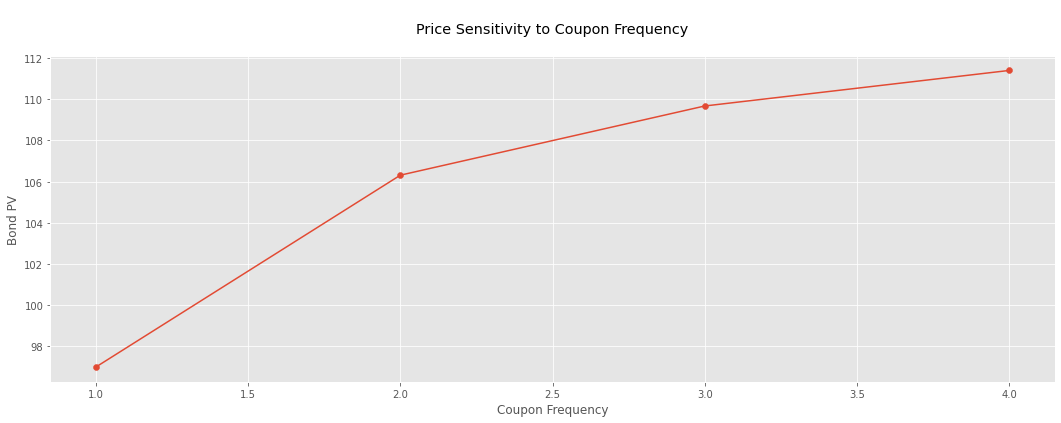

In [12]:
# Sensitivity to coupon frequency
freq_for_sensitivity = [i for i in range(1, 5)]

pv_for_freq_sensitivity = []
for i in freq_for_sensitivity:
    pv_for_freq_sensitivity.append(float(calculate_stats(yc, face, coupon, maturity, i, default_p, default_r).PV))
    
plt.figure(figsize = (18, 6))     
plt.scatter(freq_for_sensitivity, pv_for_freq_sensitivity)
plt.plot(freq_for_sensitivity, pv_for_freq_sensitivity)
plt.title('\nPrice Sensitivity to Coupon Frequency\n')
plt.xlabel('Coupon Frequency')
plt.ylabel('Bond PV')
plt.show()

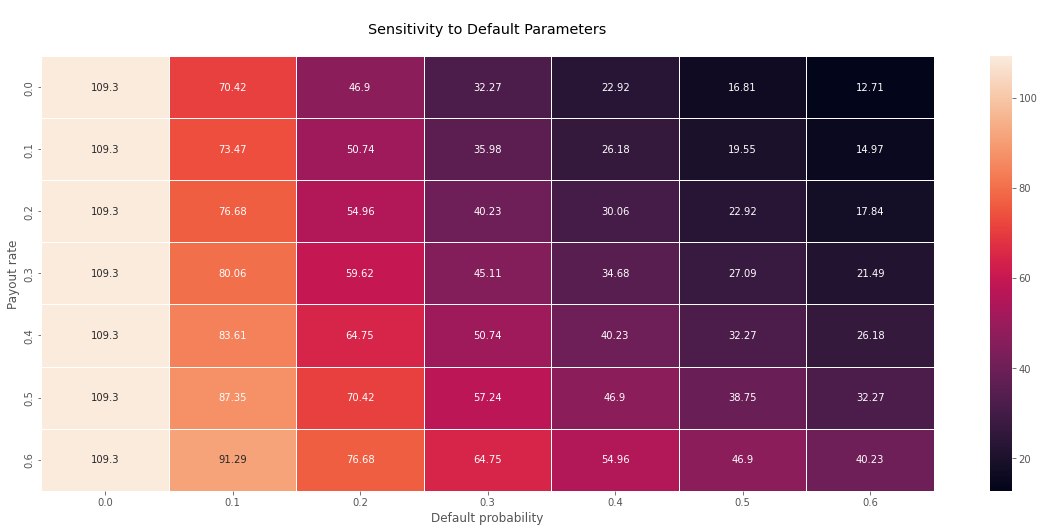

In [13]:
# Sensitivity to default probability and ratio
p_def_for_sensitivity = [i/100 for i in range(0, 70, 10)]
r_def_for_sensitivity = [i/100 for i in range(0, 70, 10)]

pv_for_def_sensitivity = {}
for p in p_def_for_sensitivity:
    pv_for_def_sensitivity[str(p)] = []
    for r in r_def_for_sensitivity:
        pv_for_def_sensitivity[str(p)].append(float(calculate_stats(yc, face, coupon, maturity, frequency, p, r).PV))
    
pv_for_def_sensitivity = pd.DataFrame(pv_for_def_sensitivity)
pv_for_def_sensitivity.index = r_def_for_sensitivity
pv_for_def_sensitivity.index.names = ['Payout rate']

plt.figure(figsize = (20, 8))
heat_map = sns.heatmap( pv_for_def_sensitivity, linewidth = 1 , annot = True, fmt='.4g')
plt.title('\nSensitivity to Default Parameters\n')
plt.xlabel('Default probability')
plt.show()